# Visualisation de l'espace latent du β-VAE

## Introduction

Le but de l'architecture développée est notamment d'obtenir un espace latent de plus pertinent possible, afin que l'agent soit capable de comprendre la manipulabilité de son environnement afin qu'il infère au mieux les conséquences des actions entreprises. Pour cela, on souhaite que l'espace latent soit 'démélé', c'est à dire que chaque facteur explicatif des variables observées soient séparées. Ainsi, lors de la première partie de ce stage, nous souhaitons visualiser la qualité de démélage du "SBD β-VAE" implémenté. Pour cela, nous allons procéder en deux temps : après que le réseau ait été entraîné avec différentes valeurs de β, je vais souhaiter visualiser chaque facteur de l'espace latent et comparer les résultats du "ground truth", afin de vérifier de façon qualitative le démélage de chaque facteur. Dans un second temps, on appliquera une métrique quantitative, qui nous permettra de qualifier de façon plus appuyée ce démélage. 

## Visualisation de l'espace

### Importation des données

In [1]:
# don't display tensorflow warnings
import os, logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Load tensorboard for visualisation after training
%load_ext tensorboard
import tensorflow as tf

#Reset of keras session
tf.keras.backend.clear_session()  

# Check of device used and tf version
print("Tensorflow version :", tf.__version__)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Tensorflow version : 2.2.0
Please install GPU version of TF


Nous souhaitons vérifier que la version de tensorflow pour le projet est bien la 2.1. Nous regardons également sur quel dispositif les calculs sont executés. Dans notre cas, nous avons bien la bonne version de tensorflow, néanmoins nous ne disposons pas de GPU lors du développement de ce projet et faisons tourner nos calculs sur le CPU.

In [2]:
# import of usefull librairies
from collections import defaultdict
import glob 
from dataset import *
from os import path
from pathlib import Path

path_absolute = Path().absolute()
# batch size for dataset visualization
batch_size = 64
data_dir = str(path_absolute)+"/dataset"
# creation of object dataset 
dataset = DataSet(data_dir, batch_size)

# relative path to data for qualitative and quantitative visualisation
path_qualitative= str(path_absolute)+"/vis_dataset/qualitative/"
path_quantitative = str(path_absolute)+"/vis_dataset/quantitative"

# relative path of csv if exist
csv_path = str(path_absolute)+"/dataframe_path_labels5.csv"
# creation of datafram from csv if exists, otherwise
# creation of csv file for labels
if (path.exists(csv_path)):
    df = pd.read_csv(csv_path)
else: 
    df = dataset.create_csv(csv_path)
    
# creation of generator
generator=dataset.create_generator(0.2,0.2,0.3,0.3)
# creation of training set
test_data_gen = dataset.create_flow(generator, "validation", df)
# transformation of training set flow to dataframe object
test_ds = tf.data.Dataset.from_generator(
    lambda: test_data_gen,
    output_types=(tf.float32, tf.string))

# caching and prefetching images for memory
test_data = dataset.prepare_for_training(test_ds)
# getting next training batch for visualisation
image_batch, label_batch = next(iter(test_data))

Found 43543 validated image filenames.


Plus tard dans le projet, nous aurons besoin de vérifier les valeurs de variances apprises par le modèle pour chacun des facteurs de l'espace latent. Pour cela, nous utiliserons un batch d'images comprises dans le jeu de test. C'est pourquoi il est nécessaire de récupérer le jeu de données et de créer un générateur ainsi qu'un objet tensorflow Dataset afin d'avoir un objet itérable que nous passeront dans l'encodeur pour en récupérer les valeurs des variances. La création du jeu de données a été effectué avec exactement les mêmes paramètres que lors de la création du jeu de données utilisé pour l'apprentissage des différents réseaux. Ainsi, dans le jeu de données, nous avons bien 43157 images, comme précédemment. 

In [3]:
# creating an instance of the keras model
from variationalAutoEncoder import *

# beta used for elbo loss
beta = 1
# latent size for encoding
latent_size = 32
#shape of input images
image_shape = (128,128,1)

vae = VariationalAutoEncoder(latent_size,beta,image_shape)

Par ailleurs, il est également nécessaire d'instancier un objet VAE. Lors de l'apprentissage de nos différents réseaux, nous avons sauvegardé les poids du réseaux dans différents fichiers selon la valeur de β. Ces sauvegardes ont eu lieu toutes les vingt epochs lors de l'apprentissage, ainsi qu'à la fin de chaque entraînement. Cela nous permet par la suite de récupérer les valeurs de ces poids sauvegardés et de les charger sur le nouveau VAE instancié.

### Visualisation qualitative du démélage de l'espace latent

(https://openreview.net/forum?id=Sy2fzU9gl)

Comme décrit précédemment, nous avons tout d'abord souhaité visualiser l'espace latent de l'architecture du variational autoencodeur développé, en s'intéressant dans un premier temps à celui dont β=1 puis ensuite à celui dont β=102. Pour effectuer cette visualisation, nous nous sommes appliqués à reproduire la figure 7. de l'article "beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework". 

Pour effectuer cela, on a tout d'abord entraîné les réseaux sur le même jeu de données, puis trié les variances apprises de l'espace latent dans l'ordre croissant. Effectivement, il est décrit dans l'article qu'un facteur possédant une variance faible va être un facteur plus démélé : c'est effectivement ce que l'on cherche à visualiser. Par la suite, pour les six premiers facteurs nous avons souhaité visualiser cinq caractéristiques différentes, correspondant à notre verité terrain, c'est à dire aux variables composant nos images que nous savons ne pas être impliquées les unes par rapport aux autres. Nous avons définies ces dernières comme étant la position de l'objet dans l'image en hauteur et en largeur, la forme de l'objet ainsi que la rotation de l'objet impliquée par le quaternion correspondant. Nous avons également voulu vérifier l'impact de la modification de lmoyenne apprise lors de l'entraînement sur une image, en la faisant varier de -3 à +3 tout en conservant la même variance. 

Pour effectuer cela, il nous a fallu construire un jeu de données : 
- concernant la position de l'objet dans l'image, nous avons créé un jeu de données correspondant à un objet dont le centre est situé dans chacun des pixels de l'image. 
- concernant la forme, un jeu de données dont aucune des caractéristique de la verité terrain ne bouge, mis à part la forme, et de même concernant la taille et le quaternion. 

Ce que nous avons souhaité exactement visualiser en effectuant ce graphique correspond à l'activation du neurone correspondant au facteur, c'est à dire à la valeur du facteur considéré dans l'espace latent dès lors que l'on fait varier telle ou telle caractéristique. En effectuant cela, on s'attend à ce qu'un seul neurone ne s'active que pour une caractéristique dès lors que l'espace est démélé. 

#### Lorsque le modèle est entraîné pour β=1

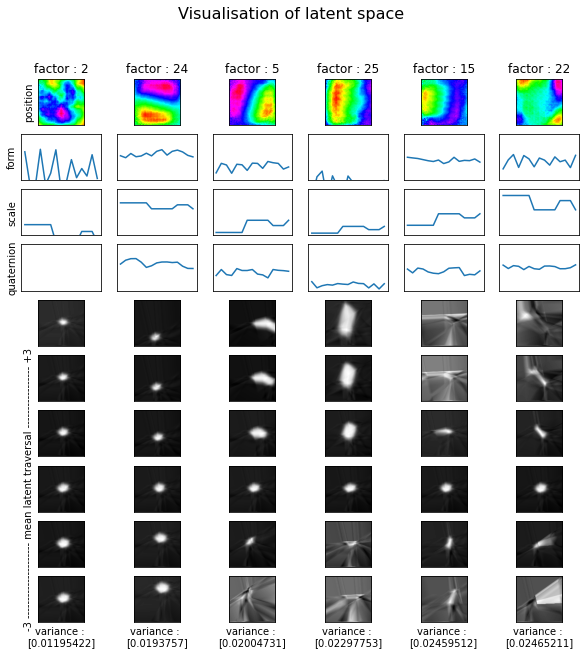

In [5]:

# load weights of the last trained model for visualizing latent space
vae.load_weights(str(path_absolute)+'/checkpoints/beta1')
# creating an instance of visualisation class
from latentSpace import *
visVae = LatentSpaceVisualisation(vae,path_qualitative, path_quantitative)

# getting the sorted factors of the latent space
variances = visVae.sorted_var(image_batch)[:6]
# getting the relevant dataset for qualitative visualisation
quaternions, typeform, echelleglob, position = visVae.create_dataset_qualitative_visualisation()
c
# getting every images that will be plot during visualisation, for each sixth first factors
pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var = visVae.get_imgs_to_plot(variances, 
                                                                                                         quaternions[0],
                                                                                                         typeform,
                                                                                                         echelleglob,
                                                                                                         quaternions,
                                                                                                         position
                                                                                                         )

# plotting the figure
visVae.plot_figure(pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var)

Les résultats obtenus lorsque β=1 coïncident relativement bien avec nos attentes. On remarque effectivement que les six premiers factors, censés être d'après l'article sur lequel on se réfère, les plus "désenmélés" possibles, encodent presque tous la position de l'objet dans l'image. Effectivement, en s'intéressant à la première ligne qui nous montre l'activation du facteur spécifié en fonction de la place du centre de l'objet dans l'image, il est possible d'interpréter que l'ensemble des facteurs s'activent lorsque l'on fait varier la position de l'objet dans l'image (le vert correspondant à une activation faible tandis que le violet correspondant à une activation très forte).

Les lignes deux à quatre ne sont pas facilement interprétable : le nombre d'images utilisées pour vérifier l'activation des neurones étant très faibles (ne possédant que peu d'objets de formes différentes, nous n'avons conservées que 12 images). Néanmoins, le résultat reste pertinant : l'espace latent de l'architecture est tout de même enmélé dès lors que β=1, l'impact du terme de régularisation étant très faible.

#### Lorsque le modèle est entraîné pour β=102

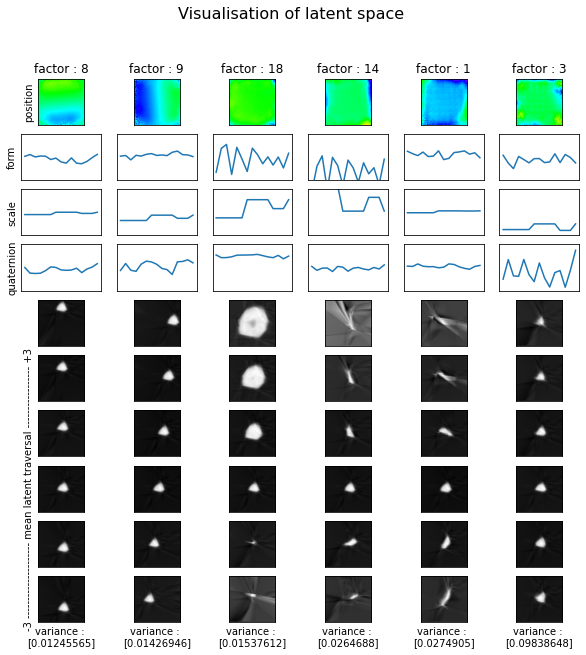

In [6]:
vae.load_weights(str(path_absolute)+'/checkpoints/beta102')
visVae = LatentSpaceVisualisation(vae,path_qualitative, path_quantitative)
# getting the sorted factors of the latent space
variances = visVae.sorted_var(image_batch)[:6]
# getting the relevant dataset for qualitative visualisation
quaternions, typeform, echelleglob, position = visVae.create_dataset_qualitative_visualisation()
# getting every images that will be plot during visualisation, for each sixth first factors
pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var = visVae.get_imgs_to_plot(variances, 
                                                                                                         quaternions[0],
                                                                                                         typeform,
                                                                                                         echelleglob,
                                                                                                         quaternions,
                                                                                                         position
                                                                                                         )
# plotting the figure
visVae.plot_figure(pos_img_list, gen_img_list, form_list, scale_list, quaternions_list, sixth_var)

Nous avons effectué la même visualisation en entraînant cette fois-ci l'architecture pour β=102, sur le même jeu de données. Les résultat obtenus sont également pertinents : on observe que les valeurs d'activations des neurones diffèrent uniquement pour les facteurs 8 et 9 lorsque l'on fait varier la position de l'objet dans l'espace. Ainsi, le facteur 8 uniquement encode la position de l'objet sur l'axe y tandis que le facteur 9 encode la position de l'objet sur l'axe x. Ces résultats concordent également sur la visualisation des images reconstruites en modifiant la moyenne apprise : rien n'est modifié mis à part la position de l'objet dans l'espace. Concernant les reste des facteurs, il est plus compliqué d'admettre qu'un facteur encode une unique caractéristique, l'interprétation des lignes 2 à 4 étant biaisées par le nombre restreint de données, néanmoins en observant les images dont on a modifié les moyennes apprises, on peut emettre l'hypothède que le facteur 18 encode la taille de l'objet dans l'image. Effectivement, l'objet reste le meme au même endroit, tandis qu'on le voit décroître au fur et à mesure que la moyenne est petite. Pour le reste des facteurs il n'est pas possible d'émettre une conclusion. 

Ainsi, lorsque β=102, on peut dire que l'espace latent encode de façon distincte la position de l'objet et potentiellement sa taille. Concernant les quaternions, cela n'est pas constaté. 
Les résultats obtenus coïncident bien que le fait que la valeur de β influe sur le désenmélage de l'espace latent.

### Visualisation quantitative du démélage de l'espace latent

Dans un second temps, nous avons souhaité vérifier de façon qualitative le désenmélage de l'espace latent. Pour cela, nous avons implémenté la "disentanglement metric" expliquée dans le même article que précédemment. Il est possible d'utiliser cette métrique dès lors que nous avons une certaine vision sur les données utilisées et notamment leur verité terrain, ce qui nous est accessible pour ce projet. 

Cette metrique consiste à créer un espace latent "moyen" qui servira de données d'entrées à un classifieur linéaire. La justesse du réseau, une fois entraîné, correspond à la valeur de la métrique. Les espaces latents moyens sont effectués à partir d'images dont chaque caractéristique de la verité terrain sont différentes, mis à part celle que l'on souhaite inférer. Cela permet par la suite, le classifieur étant un simple perceptron ne permettant aucunement de déméler l'espace par lui même, de vérifier que les différents facteurs sont bien linéairement séparés dans l'espace considéré. 

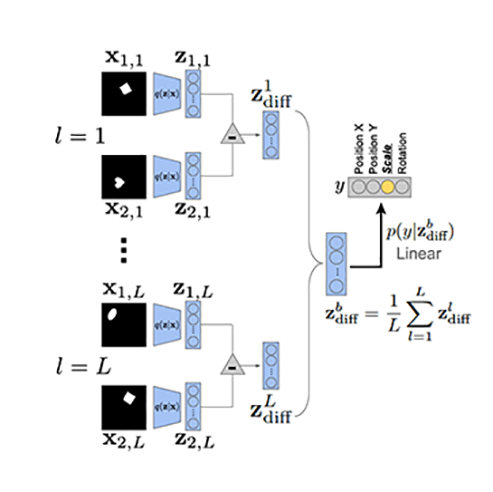

In [7]:
from PIL import Image               
# to load images
from IPython.display import display 
pil_im = Image.open(str(path_absolute)+'/img/dis_metric.png')
display(pil_im)

_schéma de l'implémentation de la "disentanglement metric", expliquée dans l'article du β-VAE._

In [8]:
# gatting all training and testing relevant dataset for training
train_quaternion, test_quaternion, train_scale, test_scale, train_form, test_form, train_positiony, test_positiony, train_positionx, test_positionx = visVae.create_dataset_quantitative_visualisation()
    

#### Lorsque le modèle est entraîné pour β=1

In [9]:
# creation of each relevant parameters for training
epoch_number = 50
nb_batch = 35
training_steps = 250
validation_steps = 100
# loading trained model for beta = 1
vae.load_weights(str(path_absolute)+'/checkpoints/beta1')
# getting generator for training set
train_data_gen = visVae.generator(nb_batch, train_positionx, train_positiony, train_form, 
                                  train_scale, train_quaternion)
# getting generator for testing set
test_data_gen = visVae.generator(nb_batch, test_positionx, test_positiony, test_form, test_scale, test_quaternion)

Pour cela il est nécessaire d'instancier une nouvelle classe VAE, dont les poids vont être chargés depuis les fichiers enregistrés lors de l'entraînement du réseau. On va ensuite créer un générateur nous permettant de récupérer au hasard une caractéristique de la verité terrain, récupérer nb_batch image du jeu de données correspondant à cette caractéristique, et retrouver l'espace latent moyen à partir de chacune de ces images passées dans l'encodeur. Ce générateur servira par la suite à entraîner le perceptron. 

In [10]:
# exemple of batch from training set
print(next(iter(train_data_gen)))

(array([[0.92418414, 1.1430895 , 1.1485966 , 0.9326584 , 0.50031817,
        1.3903073 , 1.2082368 , 1.0129725 , 1.1154475 , 0.79024076,
        0.73322606, 0.997727  , 0.8134702 , 0.8478712 , 0.65049756,
        1.0460715 , 0.87193435, 1.2469803 , 1.1049565 , 1.1788818 ,
        0.6632927 , 0.8758491 , 0.76825804, 0.88406926, 0.37374234,
        0.9910543 , 0.5765379 , 0.8641752 , 1.0516346 , 0.95678926,
        0.7607074 , 0.93576235]], dtype=float32), array([[0., 0., 0., 1., 0.]], dtype=float32))


Ci-dessus est affiché un exemple de donnée d'entrée du perceptron nous permettant de récupérer la valeur de la métrique. Cette données est constitué d'un vecteur de taille "latent_size" dont les valeurs correspondent au valeurs moyennes pour chaque facteur, ainsi que d'un vecteur one-hot encodé correspondant au label (la valeur égale à 1 correspond à la caractéristique que l'on souhaite inférer). 

In [11]:
# creation of a new sequential keras model
model = keras.Sequential()

# adding input shape to keras model, with shape (len(latent_size)) 
model.add(tf.keras.Input(shape=(32,)))
# adding output shape to keras model, with nb_class of neurons and 
# softmax activation for cross-entroy function
model.add(keras.layers.Dense(5, activation='softmax'))

# using Adagrad optimizer with learning rate = 1e-2 according to the article
opt = keras.optimizers.Adagrad(learning_rate=0.01)
# compiling the model with CategoricalCrossEntropy loss, and accuracy as metric
model.compile(optimizer=opt,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# summary the model for visualization
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 165       
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


Le perceptron implémenté ne possède qu'une unique couche, avec une couche de sortie dont la fonction d'activation est une fonction "Softmax" et la fonction de perte à minimiser étant la négative-log likelihood. Nous souhaitons par ailleurs obtenir "l'accuracy" du réseau, c'est à dire la justesse obtenue par le réseau sur un ensemble d'images. Ce réseau est très simple, et linéaire : cela permet de ne pas lui apporter une capacité lui permettant d'apprendre par lui même de désenmélé l'espace. Si cela était le cas, les résultats seraient biaisés : on pourrait très bien obtenir des résultats de justesse très bons sans toutefois que l'espace soit tout à fait désenmélé. 

In [12]:
# training the model of training set and testing on validation set
# with verbose = 0 for not displaying each results
history = model.fit(
    train_data_gen,
    validation_data = test_data_gen,
    validation_steps = validation_steps, 
    steps_per_epoch = training_steps,
    epochs = epoch_number,
    verbose = 0)

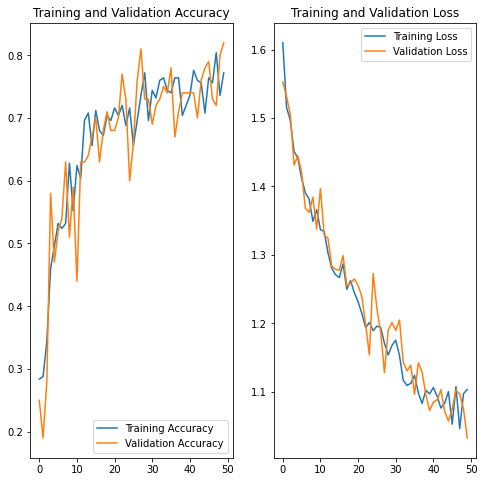

In [13]:
# printting the results of history for visualization of
# training and testing curves
import matplotlib.pyplot as plt
visVae.plot_curves_quantitative(history, epoch_number)

Pour l'apprentissage du réseau, nous avons effectué 50 epochs, avec 250 étapes pour l'entraînement et 100 pour la validationa ainsi que des batchs de 35 images. Les courbes ci-dessous correspondent à gauche à l'évolution de la justesse du réseau en fonction des épochs, et à droite l'évolution de la valeur de la perte en fonction du temps. La courbe bleue correspond aux métriques appliquées sur le jeu d'entraînement et la orange aux métriques appliquées sur le jeu de validation. Ces résultats nous permettent de visualiser que le réseau apprend bien, mais qu'il est également très performant. Effectivement, une fois l'apprentissage terminé, il est capable de prédire à environ 70% la caractéristique que l'on a souhaité visualiser à partir d'un espace latent moyen. On peut ainsi en déduire que l'espace latent est légèrement désenmélé, mais pas tout à fait. 

#### Lorsque le modèle est entraîné pour β=102

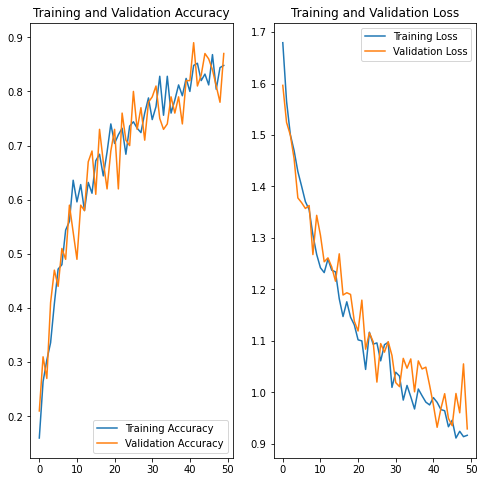

In [14]:
# loading trained model for beta = 102
vae.load_weights(str(path_absolute)+'/checkpoints/beta102')
# getting generator for training set
train_data_gen = visVae.generator(nb_batch, train_positionx, train_positiony, 
                                  train_form, train_scale, train_quaternion)
# getting generator for testing set
test_data_gen = visVae.generator(nb_batch, test_positionx, test_positiony, test_form, test_scale, test_quaternion)
# creation of a new sequential keras model
model = keras.Sequential()

# adding input shape to keras model, with shape (len(latent_size)) 
model.add(tf.keras.Input(shape=(32,)))
# adding output shape to keras model, with nb_class of neurons and 
# softmax activation for cross-entroy function
model.add(keras.layers.Dense(5, activation='softmax'))

# using Adagrad optimizer with learning rate = 1e-2 according to the article
opt = keras.optimizers.Adagrad(learning_rate=0.01)
# compiling the model with CategoricalCrossEntropy loss, and accuracy as metric
model.compile(optimizer=opt,
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

# summary the model for visualization
# creation of each relevant parameters for training
epoch_number = 50
nb_batch = 35
training_steps = 250
validation_steps = 100

# training the model of training set and testing on validation set
# with verbose = 0 for not displaying each results
history = model.fit(
    train_data_gen,
    validation_data = test_data_gen,
    validation_steps = validation_steps, 
    steps_per_epoch = training_steps,
    epochs = epoch_number,
    verbose = 0)
# printting the results of history for visualization of
# training and testing curves
import matplotlib.pyplot as plt
visVae.plot_curves_quantitative(history, epoch_number)

Nous avons effectué exactement la même démarche que ci-dessus mais en considérant cette fois-ci l'architecture du VAE pour β=102. Les courbes ci-dessus nous permettent d'affirmer que les résultats sont considérablement meilleurs : pour environ 90% des cas, le classifieur infère la bonne caractéristique. L'espace latent est alors très bien démélé lorsque β est supérieur, ce qui correspond bien aux hypothèses de départ concernant l'impact de β sur la qualité de l'espace latent, ainsi que sur les résultats obtenus lors de la visualisation de ce dernier.

## Conclusion

A travers ces différentes métriques, on peut qualifier que l'espace latent de l'architecture implémentée est relativement bonne dès lors que β=102. Effectivement l'ensemble des métriques implémentées prouvent bien que différents facteurs encodent bien séparemment les caractéristiques de la verité terrain du jeu de données considéré. Néanmoins